In [96]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
cycle538 = ["#30a2da","#fc4f30","#e5ae38","#6d904f","#8b8b8b"]

In [2]:
from scipy import stats

#### compile summaries for eval

In [37]:
events = [
    'UEFA Champions League Final',
    'French Open Finals',
    'Monaco Grand Prix',
    'Stanley Cup Playoffs Final Game 7',
    '24 Hours of Le Mans',
    'NBA Playoffs Finals Game 7',
    'The Next Web Conference Europe',
    'Recode Code Conference',
    'Google I/O',
    'Apple Worldwide Developer Conference',
    'Lenovo Tech World',
    'Xbox E3'
    ]

summary_types = [
    'engagements',
    'pr_subevents',
    'pr_e_subevents',
    'prplus_e_subevents'
    ]

data = {}
for event_name in events:
    event_filename = re.sub("\W+", "", event_name.replace('/', '').strip())
    data[event_name] = {}
    for summary_type in summary_types:
        d = pd.read_csv('data/final/summary/foreval_event_%s_summary_%s.txt' % (event_filename, summary_type), sep='\t', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
        d['event'] = event_name
        d['summary_type'] = summary_type
        data[event_name][summary_type] = d
        
    df = pd.concat(data[event_name].values())
    data[event_name] = df

allevents = list(data.values())

df = pd.concat(allevents)
df.shape

(1200, 13)

#### export all summaries file, for annotation

In [39]:
df.to_csv('data/final/summary/allsummaries_foreval.txt', sep='\t', encoding='utf-8', header=True, index=False)

In [41]:
df_deduped = df.drop_duplicates(subset='twitter_id')
df_deduped.to_csv('data/final/summary/allsummaries_foreval_deduped.txt', sep='\t', encoding='utf-8', header=True, index=False)

### import evaled summaries

In [58]:
df = pd.read_csv('data/final/summary/allsummaries_foreval.txt', sep='\t', encoding='utf-8', header=0)
df.shape

(1200, 13)

In [45]:
df_evaled = pd.read_csv('data/final/summary/allsummaries_evaled.txt', sep='\t', encoding='utf-8', header=0)
df_evaled.shape

(867, 14)

#### merge summary annotations with summary data

In [64]:
df.rename(columns={'news' : 'predicted_news'}, inplace=True)

In [69]:
df = pd.merge(df, df_evaled[['twitter_id', 'news']], on='twitter_id', how='left')
df.shape

(1200, 14)

In [103]:
df['rank'] = df.apply(lambda x: [x['rank_engagements'], x['rank_subevents']][not np.isnan(x['rank_subevents'])], axis=1)

#### add event volume

In [70]:
event_volume = {
    'UEFA Champions League Final' : 192602,
    'French Open Finals' : 23552,
    'Monaco Grand Prix' : 62212,
    'Stanley Cup Playoffs Final Game 7' : 52528,
    '24 Hours of Le Mans' : 31672,
    'NBA Playoffs Finals Game 7': 514439,
    'The Next Web Conference Europe' : 7636,
    'Recode Code Conference' : 5780,
    'Google I/O' : 25533,
    'Apple Worldwide Developer Conference' : 40027,
    'Lenovo Tech World' : 13185,
    'Xbox E3' : 86475
    }

df['event_volume'] = df['event']
df['event_volume'].replace(event_volume, inplace=True)

In [75]:
event_tweetspermin = {
    'UEFA Champions League Final' : 4387,
    'French Open Finals' : 371,
    'Monaco Grand Prix' : 855,
    'Stanley Cup Playoffs Final Game 7' : 2274,
    '24 Hours of Le Mans' : 386,
    'NBA Playoffs Finals Game 7': 11899,
    'The Next Web Conference Europe' : 20,
    'Recode Code Conference' : 34,
    'Google I/O' : 270,
    'Apple Worldwide Developer Conference' : 449,
    'Lenovo Tech World' : 51,
    'Xbox E3' : 1246
    }

df['event_tweetspermin'] = df['event']
df['event_tweetspermin'].replace(event_tweetspermin, inplace=True)

In [71]:
event_domain = {
    'UEFA Champions League Final' : 'Sporting Event',
    'French Open Finals' : 'Sporting Event',
    'Monaco Grand Prix' : 'Sporting Event',
    'Stanley Cup Playoffs Final Game 7' : 'Sporting Event',
    '24 Hours of Le Mans' : 'Sporting Event',
    'NBA Playoffs Finals Game 7': 'Sporting Event',
    'The Next Web Conference Europe' : 'Technology Conference',
    'Recode Code Conference' : 'Technology Conference',
    'Google I/O' : 'Technology Conference',
    'Apple Worldwide Developer Conference' : 'Technology Conference',
    'Lenovo Tech World' : 'Technology Conference',
    'Xbox E3' : 'Technology Conference',
    }

df['event_domain'] = df['event']
df['event_domain'].replace(event_domain, inplace=True)

#### compute accurracy
- running sum
- total

In [72]:
df['news_running_sum'] = df.groupby(['summary_type', 'event'])['news'].cumsum()

In [107]:
df['running_accuracy'] = df['news_running_sum'] / df['rank']

In [74]:
df['accuracy'] = df.groupby(['event', 'summary_type'])['news'].transform(lambda x: x.sum()) / 25

#### summary

In [77]:
df.groupby(['event_domain', 'event', 'summary_type'])['accuracy'].mean().unstack()

summary_type                                                engagements  \
event_domain          event                                               
Sporting Event        24 Hours of Le Mans                          0.44   
                      French Open Finals                           0.28   
                      Monaco Grand Prix                            0.40   
                      NBA Playoffs Finals Game 7                   0.40   
                      Stanley Cup Playoffs Final Game 7            0.40   
                      UEFA Champions League Final                  0.40   
Technology Conference Apple Worldwide Developer Conference         0.32   
                      Google I/O                                   0.76   
                      Lenovo Tech World                            0.16   
                      Recode Code Conference                       0.64   
                      The Next Web Conference Europe               0.52   
                      Xbox E3                                      0.68   

summary_type                                                pr_e_subevents  \
event_domain          event                                                  
Sporting Event        24 Hours of Le Mans                             0.92   
                      French Open Finals                              0.88   
                      Monaco Grand Prix                               0.80   
                      NBA Playoffs Finals Game 7                      0.36   
                      Stanley Cup Playoffs Final Game 7               0.44   
                      UEFA Champions League Final                     0.68   
Technology Conference Apple Worldwide Developer Conference            0.72   
                      Google I/O                                      0.80   
                      Lenovo Tech World                               0.56   
                      Recode Code Conference                          0.76   
                      The Next Web Conference Europe                  0.60   
                      Xbox E3                                         0.48   

summary_type                                                pr_subevents  \
event_domain          event                                                
Sporting Event        24 Hours of Le Mans                           0.88   
                      French Open Finals                            0.84   
                      Monaco Grand Prix                             0.88   
                      NBA Playoffs Finals Game 7                    0.48   
                      Stanley Cup Playoffs Final Game 7             0.48   
                      UEFA Champions League Final                   0.68   
Technology Conference Apple Worldwide Developer Conference          0.68   
                      Google I/O                                    0.88   
                      Lenovo Tech World                             0.48   
                      Recode Code Conference                        0.80   
                      The Next Web Conference Europe                0.44   
                      Xbox E3                                       0.48   

summary_type                                                prplus_e_subevents  
event_domain          event                                                     
Sporting Event        24 Hours of Le Mans                                 0.92  
                      French Open Finals                                  0.88  
                      Monaco Grand Prix                                   1.00  
                      NBA Playoffs Finals Game 7                          0.44  
                      Stanley Cup Playoffs Final Game 7                   0.56  
                      UEFA Champions League Final                         0.64  
Technology Conference Apple Worldwide Developer Conference                0.96  
                      Google I/O                              

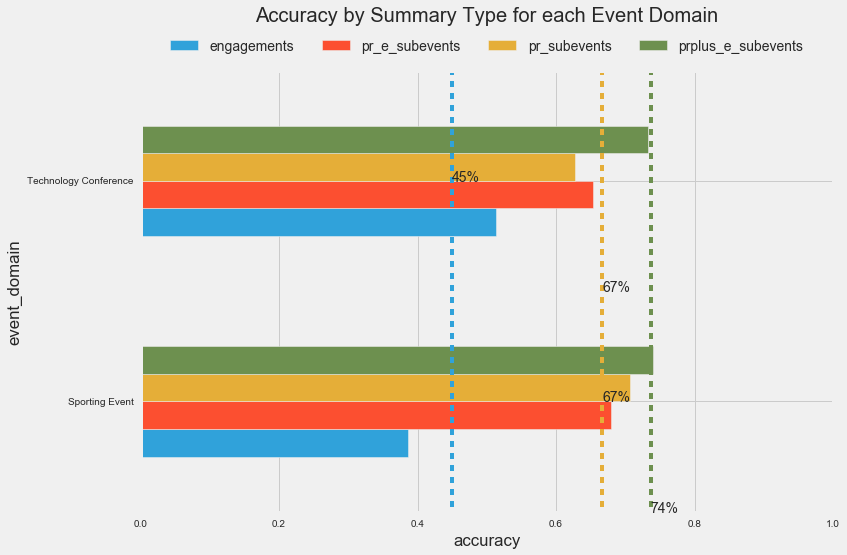

In [117]:
title = 'Accuracy by Summary Type for each Event Domain'

fig, ax = plt.subplots(figsize=(12,8))

groups = df.groupby(['event_domain', 'summary_type'])['accuracy'].mean()
means = groups.unstack().mean()

groups.unstack().plot(kind='barh', ax=ax)
plt.vlines(x=means.values, ymin=-2, ymax=12, colors=cycle538, linestyle='--')
ax.set_xlim(0,1)

for i,mean in enumerate(means):
    plt.text(mean,1-(i*.5), '%.f%%' % (100*mean))

plt.xlabel('accuracy')
plt.title(title, y=1.1)
plt.legend(markerscale=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summaryeval_%s.png' % title.replace(' ', '_'))

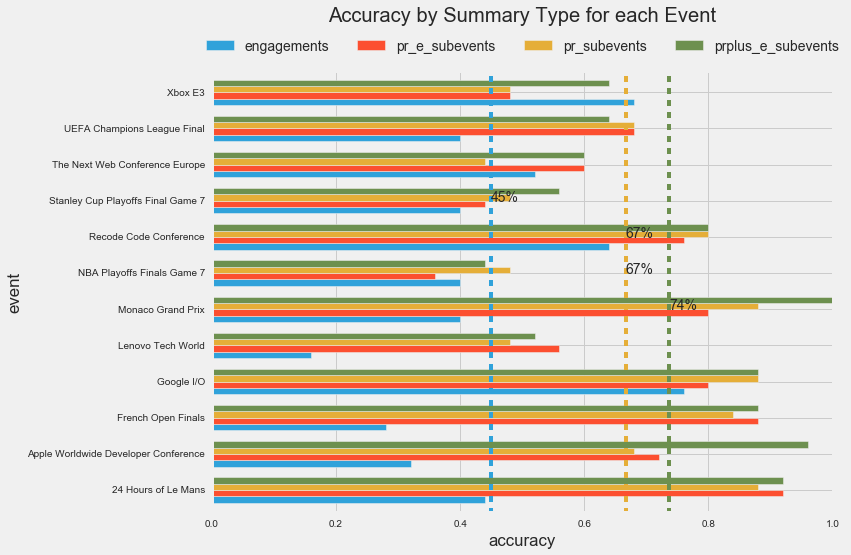

In [116]:
title = 'Accuracy by Summary Type for each Event'

groups = df.groupby(['event', 'summary_type'])['accuracy'].mean()
means = groups.unstack().mean()

fig, ax = plt.subplots(figsize=(12,8))

ax = groups.unstack().plot(kind='barh', ax=ax, width=.7)
plt.vlines(x=means.values, ymin=-2, ymax=12, colors=cycle538, linestyle='--')
ax.set_xlim(0,1)

for i,mean in enumerate(means):
    plt.text(mean,8-i, '%.f%%' % (100*mean))

plt.xlabel('accuracy')
plt.title(title, y=1.1)
plt.legend(markerscale=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summaryeval_%s.png' % title.replace(' ', '_'))

### visualize

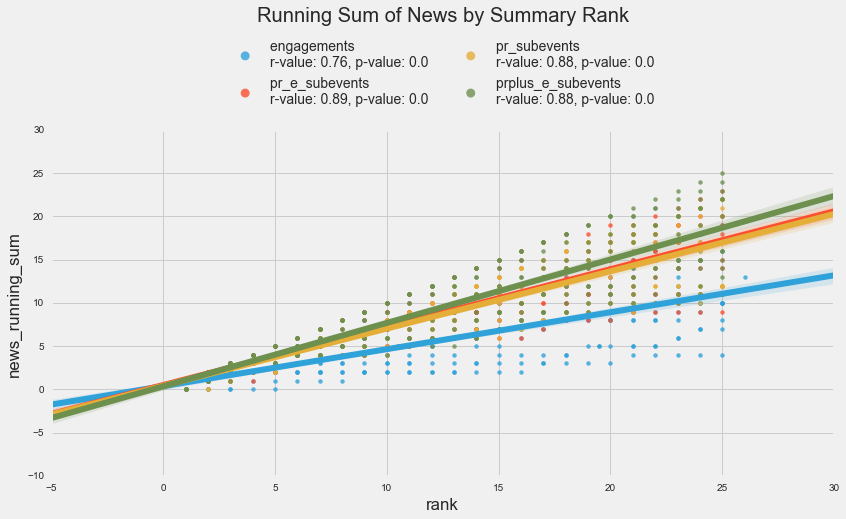

In [115]:
title = 'Running Sum of News by Summary Rank'

groups = df.groupby('summary_type')[['event', 'rank', 'news_running_sum']]

fig, ax = plt.subplots(figsize=(12,8))

for group, dat in groups:
    output = stats.linregress(x=dat['rank'], y=dat['news_running_sum'])
    sns.regplot(data=dat, x='rank', y='news_running_sum', label='%s \nr-value: %s, p-value: %s' % (group, round(output.rvalue,2), round(output.pvalue,2)))

plt.title(title, y=1.3)
plt.legend(markerscale=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summaryeval_%s.png' % title.replace(' ', '_'))

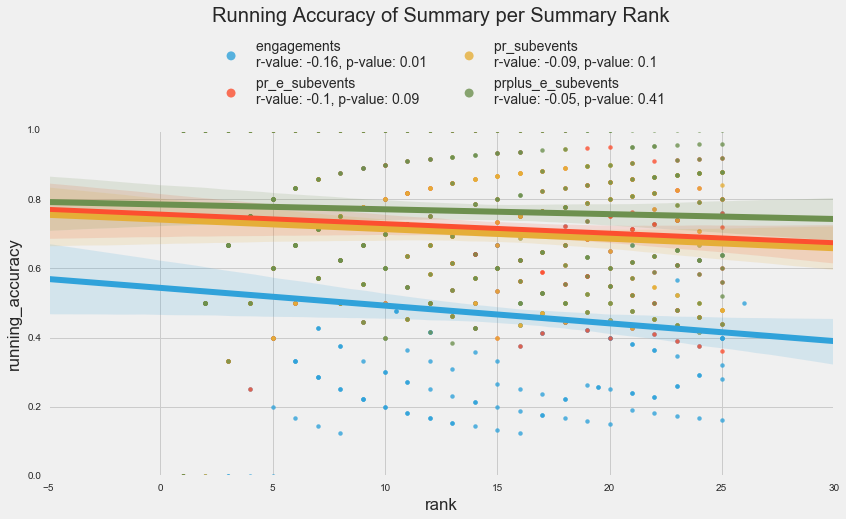

In [114]:
title = 'Running Accuracy of Summary per Summary Rank'

groups = df.groupby('summary_type')[['event', 'rank', 'running_accuracy']]

fig, ax = plt.subplots(figsize=(12,8))

for group, dat in groups:
    output = stats.linregress(x=dat['rank'], y=dat['running_accuracy'])
    sns.regplot(data=dat, x='rank', y='running_accuracy', label='%s \nr-value: %s, p-value: %s' % (group, round(output.rvalue,2), round(output.pvalue,2)))    

ax.set_ylim(0,1)
    
plt.title(title, y=1.3)
plt.legend(markerscale=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summaryeval_%s.png' % title.replace(' ', '_'))

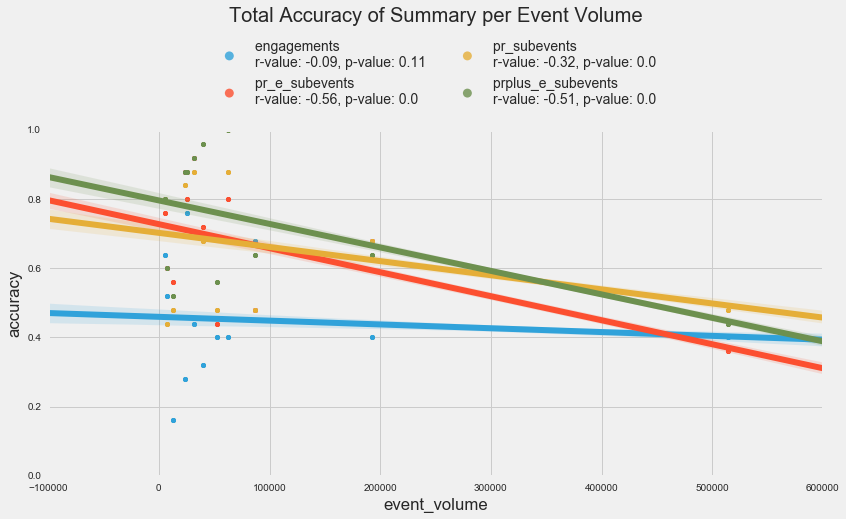

In [122]:
title = 'Total Accuracy of Summary per Event Volume'

groups = df.groupby('summary_type')[['event', 'event_volume', 'accuracy']]

fig, ax = plt.subplots(figsize=(12,8))

for group, dat in groups:
    output = stats.linregress(x=dat['event_volume'], y=dat['accuracy'])
    sns.regplot(data=dat, x='event_volume', y='accuracy', label='%s \nr-value: %s, p-value: %s' % (group, round(output.rvalue,2), round(output.pvalue,2)))    

ax.set_ylim(0,1)
    
plt.title(title, y=1.3)
plt.legend(markerscale=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summaryeval_%s.png' % title.replace(' ', '_'))

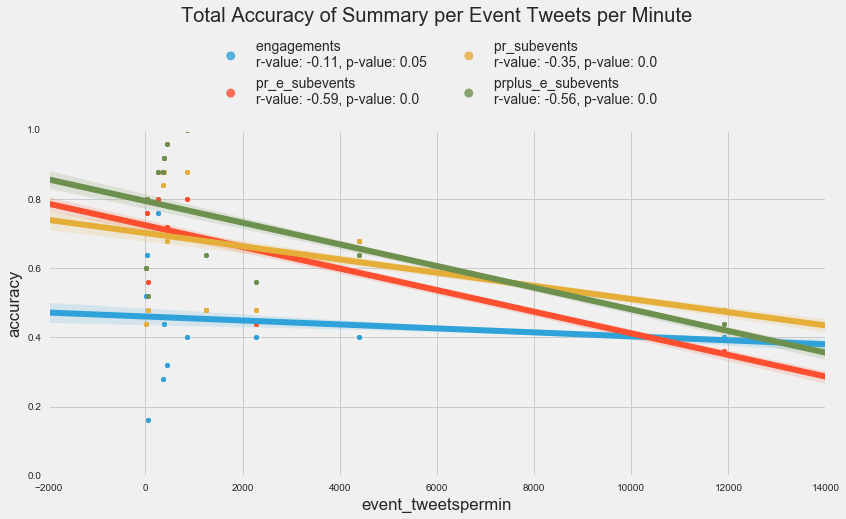

In [121]:
title = 'Total Accuracy of Summary per Event Tweets per Minute'

groups = df.groupby('summary_type')[['event', 'event_tweetspermin', 'accuracy']]

fig, ax = plt.subplots(figsize=(12,8))

for group, dat in groups:
    output = stats.linregress(x=dat['event_tweetspermin'], y=dat['accuracy'])
    sns.regplot(data=dat, x='event_tweetspermin', y='accuracy', label='%s \nr-value: %s, p-value: %s' % (group, round(output.rvalue,2), round(output.pvalue,2)))    

ax.set_ylim(0,1)
    
plt.title(title, y=1.3)
plt.legend(markerscale=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summaryeval_%s.png' % title.replace(' ', '_'))